## XGBoost
- With dataset that columns containing 50% or more negative values are removed and rows with negative values are removed

# XGBoost with Grid Search Setup
- Grid Search is used to find the best parameters for the model
- It is a brute force method that tries all the combinations of parameters to find the best combination [cv = n means (n-fold cross validation)]

Fitting 5 folds for each of 64 candidates, totalling 320 fits
Best parameters found:  {'learning_rate': 0.1, 'max_depth': 2, 'n_estimators': 300}
XGBoost Mean Absolute Error: 1.2785628731096539
XGBoost Mean Squared Error: 3.2099397247417603
XGBoost Root Mean Squared Error: 1.7916304654536772
XGBoost R2 Score: 0.9779564420416262


<Figure size 1000x1200 with 0 Axes>

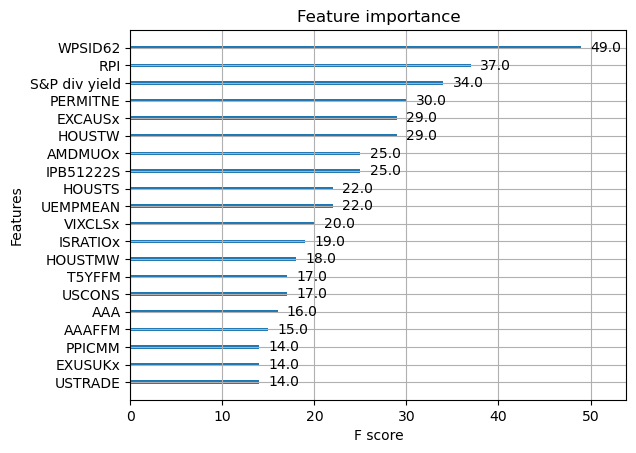

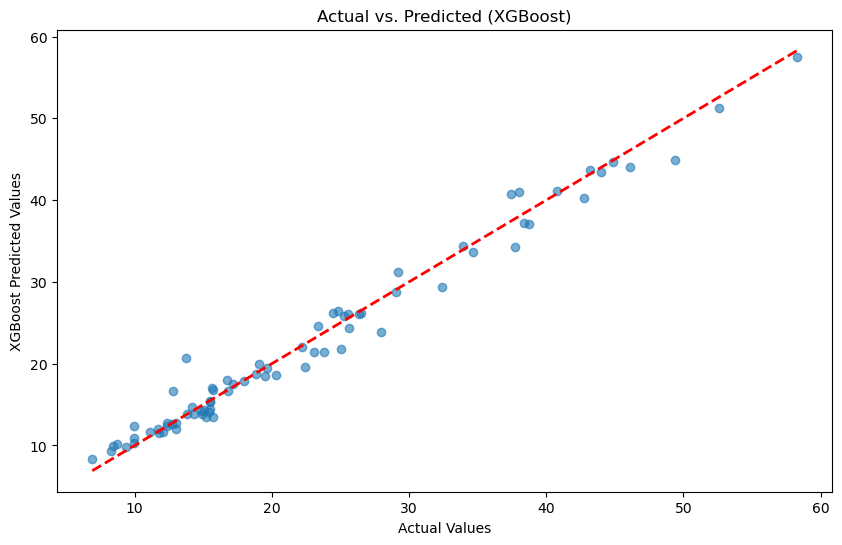

In [3]:
import pandas as pd
import numpy as np
import xgboost as xgb
from xgboost import plot_importance
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
#Grid Search
from sklearn.model_selection import GridSearchCV

# Load the cleaned dataset
df = pd.read_csv('../../../Data/macro_features_and_real_oil_prices_log_tranferred_dropped_Nan_skipped_neg_and_zeros_for_log.csv', skiprows=1)

# Drop the "0" column (unnecessary index column)
df = df.drop(columns=['0'])

# drop the original date column
df = df.drop(columns=['date'])

df.head()

# Splitting the data into features and target
X = df.drop('Real Oil Prices', axis=1)
y = df['Real Oil Prices']

# Split the data into training and testing sets (80% for training and 20% for testing)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the hyperparameters and their possible values
param_grid = {
    'n_estimators': [10, 50, 100, 300],
    'learning_rate': [0.001, 0.01, 0.1, 0.3],
    'max_depth': [1, 2, 3, 5],
}

# Initialize the XGBoost regressor
xgb_model = xgb.XGBRegressor(objective ='reg:squarederror', seed=42)

# Set up the grid search
grid_search = GridSearchCV(xgb_model, param_grid, cv=5, scoring='neg_mean_squared_error', verbose=1, n_jobs=-1)

# Fit the grid search to the data
grid_search.fit(X_train, y_train)

# Print the best parameters
print("Best parameters found: ", grid_search.best_params_)

# Use the best model to make predictions
best_xgb_model = grid_search.best_estimator_
predictions = best_xgb_model.predict(X_test)

# Evaluate the model
xgb_mae = mean_absolute_error(y_test, predictions)
xgb_mse = mean_squared_error(y_test, predictions)
xgb_r2 = r2_score(y_test, predictions)
# Compute RMSE
xgb_rmse = np.sqrt(xgb_mse)

print(f"XGBoost Mean Absolute Error: {xgb_mae}")
print(f"XGBoost Mean Squared Error: {xgb_mse}")
print(f"XGBoost Root Mean Squared Error: {xgb_rmse}")
print(f"XGBoost R2 Score: {xgb_r2}")

# Plotting feature importances for the best model
plt.figure(figsize=(10, 12))
plot_importance(best_xgb_model, max_num_features=20)
plt.show()

# Actual vs. Predicted scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(y_test, predictions, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual Values')
plt.ylabel('XGBoost Predicted Values')
plt.title('Actual vs. Predicted (XGBoost)')
plt.show()

### Learning Curve

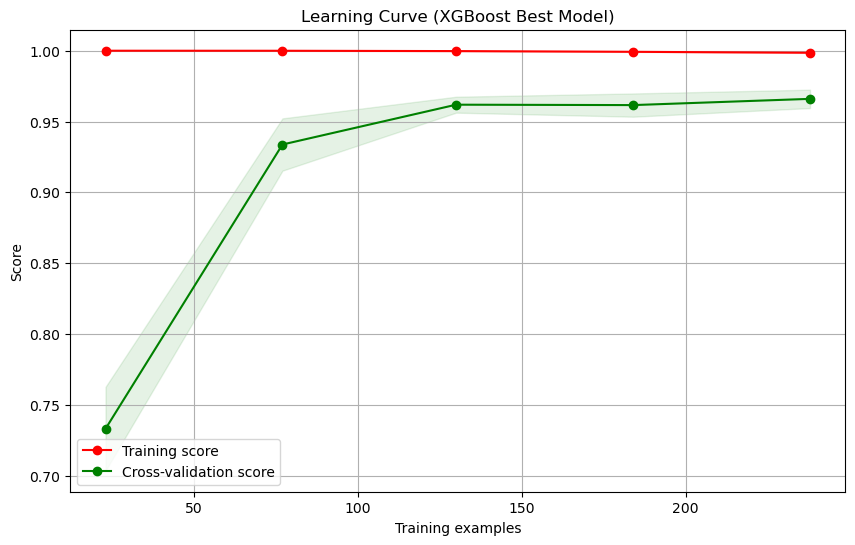

In [4]:
from sklearn.model_selection import learning_curve

def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None, n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    plt.figure(figsize=(10,6))
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    # Fill between lines to indicate standard deviation
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.1, color="g")
    
    # Plot the average training and test scores
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")

    plt.legend(loc="best")
    return plt

# Plot the learning curve for the XGBoost model
plot_learning_curve(best_xgb_model, "Learning Curve (XGBoost Best Model)", X_train, y_train, cv=5)
plt.show()

- The Training score curve (in red) shows how the model's performance on the training data changes as more data is used.
- The Cross-validation score curve (in green) shows how the model's performance on a validation set changes as more training data is used.